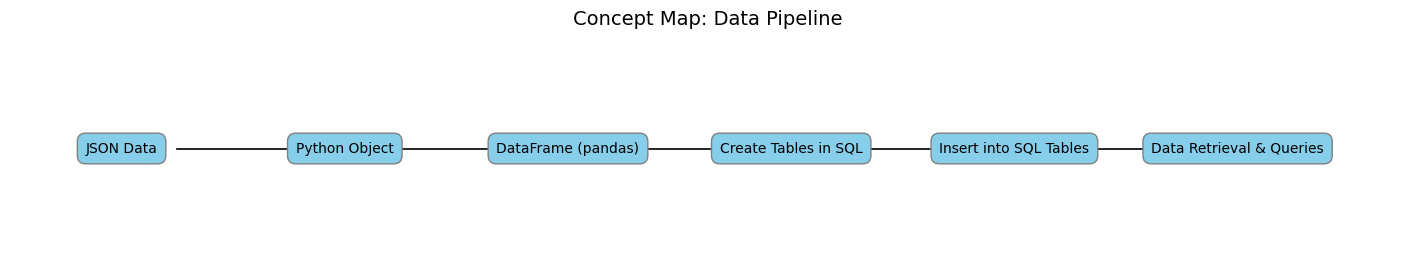

<h3 style="color:white; font-weight:bold;">Import necessary libraries</h3>


In [ ]:
import json
import pandas as pd
import mysql.connector

In [ ]:
import streamlit as st

<h3 style="color:white; font-weight:bold;">1) COLLECT THE COMPETITION DATA FROM THE API ENDPOINTS</h3>

In [ ]:
import requests

url = "https://api.sportradar.com/tennis/trial/v3/en/competitions.json?api_key=yourkey"

headers = {"accept": "application/json"}

response = requests.get(url, headers=headers)

print(response.text)

In [ ]:
#json string to python object
data = json.loads(response.text)

In [ ]:
#print data
data

In [ ]:
#check number of keys
data.keys()

In [ ]:
# Extract keys from the competition dictionariesto check  how many keys are present
competition_keys = set()

# Loop through each competition
for competition in data['competitions']:
    competition_keys.update(competition.keys())

print(competition_keys)

In [ ]:
# Assuming data['competitions'] is the list of competitions
category_keys = set()

# Loop through each competition
for competition in data['competitions']:
    # Check if 'category' key exists, and extract its keys
    if 'category' in competition:
        category_keys.update(competition['category'].keys())

print(category_keys)

In [ ]:
# creating list of dict to store category_id and category_name using list comprehension
category_table= [
    {'category_id': comp['category']['id'], 'category_name': comp['category']['name']}
    for comp in data['competitions']
]
category_table

In [ ]:
# Converting python object of category_table to DataFrame using pandas
df_cat = pd.DataFrame(category_table)

# Displaying the DataFrame
print(df_cat)

In [ ]:
#count values
df_cat['category_id'].value_counts()


<h3 style="color:white; font-weight:bold;">since some rows are keep repeating , need to do a check on unique entries</h3>

In [ ]:
for column in df_cat.columns:
    unique_vals = df_cat[column].unique() # in each column check for unique values
    print(f"Column: {column}")
    print(f"Unique Count: {len(unique_vals)}")
    print(f"Unique Values: {unique_vals}\n")  #\n for next line print

In [ ]:
#lets check how many unique entries present
df_unique_categories = df_cat.drop_duplicates(subset=["category_id", "category_name"])
df_unique_categories

In [ ]:
df_unique_categories.info()

In [ ]:
for column in df_unique_categories.columns:
    unique_vals = df_unique_categories[column].unique()
    print(f"Column: {column}")
    print(f"Unique Count: {len(unique_vals)}")
    #print(f"Unique Values: {unique_vals}\n")

<h3 style="color:white; font-weight:bold;">creating competions_table</h3>

In [ ]:
#using list comprehension 
competitions_table_1 = [
    {
        'competition_id': comp.get('id'),
        'competition_name': comp.get('name'),
        'parent_id': comp.get('parent_id'),
        'type': comp.get('type'),
        'gender': comp.get('gender'),
        'category_id': comp.get('category', {}).get('id')  #  safely extract category_id--get function handles none as well
    }
    for comp in data['competitions']
]


In [ ]:
competitions_table_1

In [ ]:
# Convert to DataFrame
df_comp = pd.DataFrame(competitions_table_1)

In [ ]:
print(df_comp)

In [ ]:
df_comp.info()

In [ ]:
#check unique values
for column in df_comp.columns:
    unique_vals = df_comp[column].unique()
    print(f"Column: {column}")
    print(f"Unique Count: {len(unique_vals)}")
    print(f"Unique Values: {unique_vals}\n")

<h3 style="color:white; font-weight:bold;">dataframe to sql tables</h3>


In [ ]:
import mysql.connector

#Connect to MySQL server
connection = mysql.connector.connect(
    host='localhost',
    user='root',
    password='password'  # Change to your actual password
)
cursor = connection.cursor()

Create a New Database 

In [ ]:
# Create database 
cursor.execute("CREATE DATABASE IF NOT EXISTS Tennis")
cursor.execute("USE Tennis")

In [ ]:
# Create Categories table
cursor.execute("""
CREATE TABLE IF NOT EXISTS Categories (
    category_id VARCHAR(50) PRIMARY KEY,
    category_name VARCHAR(100) NOT NULL
)
""")

In [ ]:
#  Create Competitions table
cursor.execute("""
CREATE TABLE IF NOT EXISTS Competitions (
    competition_id VARCHAR(50) PRIMARY KEY,
    competition_name VARCHAR(100) NOT NULL,
    parent_id VARCHAR(50),
    type VARCHAR(20) NOT NULL,
    gender VARCHAR(10) NOT NULL,
    category_id VARCHAR(50),
    FOREIGN KEY (category_id) REFERENCES Categories(category_id)
)
""")


In [ ]:
#  Insert data into Categories
categories_data = df_unique_categories.values.tolist()
cursor.executemany("""
INSERT IGNORE INTO Categories (category_id, category_name)
VALUES (%s, %s)
""", categories_data)

In [ ]:
#  Insert data into Competitions
competitions_data = df_comp[[
    'competition_id', 'competition_name', 'parent_id', 'type', 'gender', 'category_id'
]].values.tolist()

cursor.executemany("""
INSERT IGNORE INTO Competitions (
    competition_id, competition_name, parent_id, type, gender, category_id
)
VALUES (%s, %s, %s, %s, %s, %s)
""", competitions_data)

In [ ]:
# Step 7: Commit and close
connection.commit()
cursor.close()
connection.close()


<h3 style="color:white; font-weight:bold;">COLLECT THE COMPLEXES DATA FROM THE API ENDPOINTS</h3>


In [ ]:
import requests

url = "https://api.sportradar.com/tennis/trial/v3/en/complexes.json?api_key=yourkey"

headers = {"accept": "application/json"}

response = requests.get(url, headers=headers)

print(response.text)

In [ ]:
#json string to python object
data_1 = json.loads(response.text)

In [ ]:
#print data
data_1

In [ ]:
# creating list of dict to store omplex_id and complex_name using list comprehension
complex_table= [
    {'complex_id': comp['id'], 'complex_name': comp['name']}
    for comp in data_1['complexes']
]
complex_table


In [ ]:
# Converting python object of complex_table to DataFrame using pandas
df_complex = pd.DataFrame(complex_table)

# Displaying the DataFrame
print(df_complex.head(20))

In [ ]:
#check the table for duplicates
df_complex.describe()

In [ ]:
#sanity check for unique values
for column in df_complex.columns:
    unique_vals = df_complex[column].unique()
    print(f"Column: {column}")
    print(f"Unique Count: {len(unique_vals)}")
    print(f"Unique Values: {unique_vals}\n")

In [ ]:
# Get unique values
unique_values = df_complex['complex_id'].nunique()
print(unique_values)

venue_id--> primary key
venue_name
city_name
country_name
country_code
timezone
complex_id-->foreign key refernce

In [ ]:
df_venues = pd.DataFrame([
    {
        'venue_id': venue['id'],
        'venue_name': venue['name'],
        'city_name': venue.get('city_name'),
        'country_name': venue.get('country_name'),
        'country_code': venue.get('country_code'),
        'timezone': venue.get('timezone'),
        'complex_id': complexx['id']
    }
    for complexx in data_1['complexes']
    for venue in complexx.get('venues', [])
])

In [ ]:
# check unique values in column
for column in df_venues.columns:
    unique_vals = df_venues[column].unique()
    print(f"Column: {column}")
    print(f"Unique Count: {len(unique_vals)}\n")
    #print(f"Unique Values: {unique_vals}\n")

In [ ]:
print(df_venues)

In [ ]:
#dataframes are ready, just inserting into sql

import mysql.connector

# Connect to MySQL
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='password',    # your password
    database='Tennis'   # your database name
)

cursor = conn.cursor()

In [ ]:
#create complex table
cursor.execute("""
CREATE TABLE IF NOT EXISTS Complexes (
    complex_id VARCHAR(50) PRIMARY KEY,
    complex_name VARCHAR(255) NOT NULL
)
""")

In [ ]:
#create venue table
cursor.execute("""
CREATE TABLE IF NOT EXISTS Venues (
    venue_id VARCHAR(50) PRIMARY KEY,
    venue_name VARCHAR(255) NOT NULL,
    city_name VARCHAR(100),
    country_name VARCHAR(100),
    country_code VARCHAR(10),
    timezone VARCHAR(100),
    complex_id VARCHAR(50),
    FOREIGN KEY (complex_id) REFERENCES Complexes(complex_id)
)
""")

Insert Data into Complexes

In [ ]:
complex_data = df_complex.values.tolist()

#insert data into complexs
cursor.executemany("""
INSERT IGNORE INTO Complexes (complex_id, complex_name)
VALUES (%s, %s)
""", complex_data)

Insert Data into Venues

In [ ]:
complex_venues = df_venues.values.tolist()


#insert data to venues
cursor.executemany("""
INSERT IGNORE INTO Venues (
    venue_id, venue_name, city_name, country_name, country_code, timezone, complex_id
)
VALUES (%s, %s, %s, %s, %s, %s, %s)
""", complex_venues)

In [ ]:
 #Commit and Close Connection
conn.commit()
conn.close()



<h3 style="color:white; font-weight:bold;">COLLECT THE DOUBLES COMPETITOR RANKINGS DATA FROM THE API

ENDPOINTS</h3>


In [ ]:
import requests

url = "https://api.sportradar.com/tennis/trial/v3/en/double_competitors_rankings.json?api_key=yourkey"

headers = {"accept": "application/json"}

response_2 = requests.get(url, headers=headers)

print(response_2.text)

In [ ]:
data_2 = json.loads(response_2.text)

In [ ]:
data_2

In [ ]:
#check keys
data_2.keys()

In [ ]:
# Extract data using list comprehension
Competitor_Rankings = [
    {
        'rank': competitor['rank'],
        'movement': competitor['movement'],
        'points': competitor['points'],
        'competitions_played': competitor['competitions_played'],
        'competitor_id': competitor['competitor']['id']
    }
    for ranking in data_2['rankings']
    for competitor in ranking['competitor_rankings']
]


In [ ]:
# Convert to DataFrame
df_Competitor_Rankings = pd.DataFrame(Competitor_Rankings)
print(df_Competitor_Rankings)

In [ ]:
# Assuming your DataFrame is called df
df_filtered = df_Competitor_Rankings[df_Competitor_Rankings['rank'] <= 5][['competitor_id', 'rank']]

# Display the filtered DataFrame
print(df_filtered)
len(df_filtered['competitor_id'])

In [ ]:
df_Competitor_Rankings.info()

In [ ]:
#check unique values
for column in df_Competitor_Rankings.columns:
    unique_vals = df_Competitor_Rankings[column].unique()
    print(f"Column: {column}")
    print(f"Unique Count: {len(unique_vals)}")
    #print(f"Unique Values: {unique_vals}\n")

Competitors Table
This table will store detailed information about each competitor.

In [ ]:
# Suppose  JSON object is stored in a variable called data
competitors = [
    {
        'competitor_id': comp['competitor'].get('id'),
        'name': comp['competitor'].get('name'),
        'country': comp['competitor'].get('country'),
        'country_code': comp['competitor'].get('country_code'),
        'abbreviation': comp['competitor'].get('abbreviation')
    }
    for ranking in data_2['rankings']
    for comp in ranking.get('competitor_rankings', [])
]

In [ ]:
# Step 2: Convert the extracted data into a DataFrame
df_competitors = pd.DataFrame(competitors)

In [ ]:
#check unique count
for column in df_competitors.columns:
    unique_vals = df_competitors[column].unique()
    print(f"Column: {column}")
    print(f"Unique Count: {len(unique_vals)}")
    #print(f"Unique Values: {unique_vals}\n")

In [ ]:
# Display the DataFrame
print(df_competitors)

In [ ]:
df_competitors.info()

In [ ]:
# dataframes are ready, lets insert data
import mysql.connector

# Connect to the MySQL database
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="password", #your password
    database="Tennis"
)
cursor = conn.cursor()


In [ ]:
# Create Competitors table
cursor.execute("""
CREATE TABLE IF NOT EXISTS Competitors (
    competitor_id VARCHAR(50) PRIMARY KEY,
    name VARCHAR(100) NOT NULL,
    country VARCHAR(100) NOT NULL,
    country_code CHAR(3) NOT NULL,
    abbreviation VARCHAR(10) NOT NULL
);
""")

In [ ]:
# Prepare the data from df_competitors
competitor_data = df_competitors.values.tolist()

# Insert into Competitors
cursor.executemany("""
INSERT IGNORE INTO Competitors (competitor_id, name, country, country_code, abbreviation)
VALUES (%s, %s, %s, %s, %s)
""", competitor_data)

conn.commit()

In [ ]:

# Create Rankings table
cursor.execute("""
CREATE TABLE IF NOT EXISTS Competitor_Rankings (
    rank_id INT PRIMARY KEY AUTO_INCREMENT,
    `rank` INT NOT NULL,
    movement INT NOT NULL,
    points INT NOT NULL,
    competitions_played INT NOT NULL,
    competitor_id VARCHAR(50),
    FOREIGN KEY (competitor_id) REFERENCES Competitors(competitor_id)
);
""")

In [ ]:
# Prepare the data from df_rankings
ranking_data = df_Competitor_Rankings[['rank', 'movement', 'points', 'competitions_played', 'competitor_id']].values.tolist()

# Insert into Rankings
cursor.executemany("""
INSERT IGNORE INTO Competitor_Rankings (`rank`, movement, points, competitions_played, competitor_id)
VALUES (%s, %s, %s, %s, %s)
""", ranking_data)

In [ ]:
conn.commit()

In [ ]:
# Close the cursor and connection
cursor.close()
conn.close()